# "Publishable graphics with MATLAB"... in Python :P

I'm trying to replicate [this nice tutorial by Martin Trauth](https://mres.uni-potsdam.de/index.php/2017/02/09/create-publishable-graphics-with-matlab/). 

It generates data and fits a model to produce this plot:

<img src="http://141.89.112.21/wp-content/uploads/2017/02/publishable_graphcs_vs3.png" width=600 />

I'm going to stick somewhat closely to Martin's code, but with some exceptions:

- I'll use [recommended best practice](https://towardsdatascience.com/stop-using-numpy-random-seed-581a9972805f) for NumPy's random number generation pattern (not just `np.random.seed(0)`, which is not safe).
- I'll use `matplotlib`'s object-oriented API, because it's more flexible than the procedural MATLAB style of the PyPlot interface.
- I'm not going to put all the variables into one array, because it's not my usual practice; I tend to see arrays as homogenous 'lumps' of data, not tables of data (I'd use `pandas` for that). This saves a lot of indexing to 'reach' into the `data` array.

## Make some data

In [99]:
import numpy as np
import scipy.optimize as so

rng = np.random.default_rng(999)

# How many data points do we want?
n = 26

# Generate synthetic variables x, y and error e.
x = np.linspace(0.5, 3.0, n) + 0.2 * rng.standard_normal(n)
y = 3 + 0.2 * np.exp(x) + 0.5 * rng.standard_normal(n)
e = np.abs(rng.standard_normal(n))

Notice that `y` is generated here by the function 

$$ \hat{y} = f(x) = c_0 + c_1 \mathrm{e}^{x}$$

where $c_0$ and $c_1$ are the coefficients of the function, equal to 3.0 and 0.2 respectively.

This is the function we're going to try to fit. But we don't **know** the function, so I have not defined a Python function for it yet. We're pretending it's hidden &mdash; buried in the data, if you like.

## Fit a model

We'll use [`scipy.optimize.curve_fit()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) because it's convenient and I think it does exactly what we want.

First we define the model as a Python function expressing the function $f$ above.

In [100]:
def model(t, c0, c1):
    """The non-linear model we're fitting."""
    return  c0 + c1 * np.exp(t)

# Define a domain.
t = np.linspace(x.min(), x.max(), n)

# Unweighted solution.
(c0, c1), pcov = so.curve_fit(model, x, y, p0=(0, 0), method='lm')
y_hat_fit = model(t, c0, c1)

# Weighted solution.
(c0, c1), pcov = so.curve_fit(model, x, y, p0=(0, 0), sigma=e, method='lm')
y_hat_fit_weighted = model(t, c0, c1)

We can take a look at these coefficients; we know they should be 3.0 and 0.2:

In [101]:
c0, c1

(2.954089846079857, 0.21970627478563665)

## Make a plot

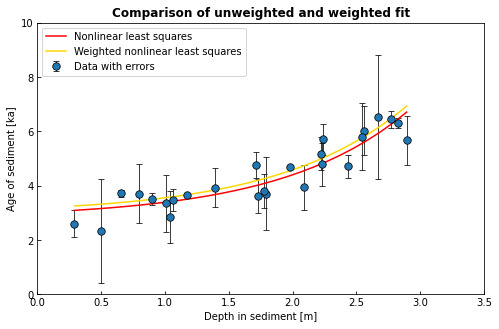

In [102]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))

params = {'elinewidth': 0.75,
          'capsize': 3,
          'markersize': 15,
          'markerfacecolor': 'C0',
          'markeredgewidth': 0.75,
         }

ax.errorbar(x, y, yerr=e, fmt='k.', label='Data with errors', **params)
ax.plot(t, y_hat_fit, 'r', label='Nonlinear least squares')
ax.plot(t, y_hat_fit_weighted, 'gold', label='Weighted nonlinear least squares')
ax.tick_params(direction="in")
ax.set_title('Comparison of unweighted and weighted fit', fontweight='bold')
ax.set_xlim(0, 3.5)
ax.set_xlabel('Depth in sediment [m]')
ax.set_ylim(0, 10)
ax.set_ylabel('Age of sediment [ka]')
ax.legend()

plt.savefig('Figure.svg')
plt.savefig('Figure.png', dpi=300)
plt.show()

## Another way, using `least_squares`

I'm not smart enough to know why this yields a different result from the unweighted least squares solution we get from `curve_fit()`, above.

In [103]:
def residual(phi, y, t):
    return y - model(t, phi[0], phi[1])

solution = so.least_squares(residual, x0=(0, 0), args=(y, t), method='lm')

c0, c1 = solution.x

y_hat_lsq = model(t, c0, c1)

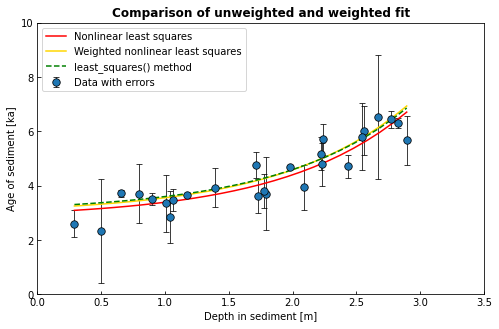

In [106]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))

params = {'elinewidth': 0.75,
          'capsize': 3,
          'markersize': 15,
          'markerfacecolor': 'C0',
          'markeredgewidth': 0.75,
         }

ax.errorbar(x, y, yerr=e, fmt='k.', label='Data with errors', **params)
ax.plot(t, y_hat_fit, 'r', label='Nonlinear least squares')
ax.plot(t, y_hat_fit_weighted, 'gold', label='Weighted nonlinear least squares')
ax.plot(t, y_hat_lsq, 'g--', label='least_squares() method')
ax.tick_params(direction="in")
ax.set_title('Comparison of unweighted and weighted fit', fontweight='bold')
ax.set_xlim(0, 3.5)
ax.set_xlabel('Depth in sediment [m]')
ax.set_ylim(0, 10)
ax.set_ylabel('Age of sediment [ka]')
ax.legend()

plt.savefig('Figure.svg')
plt.savefig('Figure.png', dpi=300)
plt.show()

---
[Thanks to Martin Trauth](http://mres.uni-potsdam.de/index.php/2017/02/09/create-publishable-graphics-with-matlab/)